# BrAIn: A comprehensive artificial intelligence-based morphology analysis system for brain organoids and neuroscience

# Libraries

In [32]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tqdm import tqdm



# Classification

This tutorial describes how to use a trained classification model to automatically detect abnormalities or budding phenotypes in brain organoid microscopy images.

✅ 1. Requirements

Make sure the following libraries are installed:

In [ ]:
pip install tensorflow numpy pillow

📂 2. Input Files
* A .h5 classification model (e.g., classification_model_densenet121anormal.h5 or classification_model_densenet121budding.h5)
* Microscopy image(s) in .jpg, .png, or .tif format
* Model input size should match the one used during training (e.g., 550×550 pixels)

🧪 3. Run the Classifier

Use the following function to classify a single organoid image as "Normal" or "Abnormal" (or "Budding").

📌 Notes
* If you are using the budding classifier, you may change "Abnormal" → "Budding" in the function above.
* This function supports binary classification (e.g., Normal vs Budding / Abnormal).

## Normal - Abnormal Classification

In [ ]:

def classify_organoid_image(model_path, image_path, target_size=(550, 550)):
   
    model = load_model(model_path)

    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = img_array / 255.0  

    prediction = model.predict(img_array)[0][0]  

    if prediction >= 0.5:
        prediction_label = "Anormal"
    else:
        prediction_label = "Normal"

    return prediction_label, float(prediction)

In [27]:
model_path = "/Users/burakkahveci/Documents/Codes/BrAIn/revision/models/classification_model_densenet121anormal.h5"
image_path = "/Users/burakkahveci/Documents/Codes/BrAIn/revision/a5 10x_d2.jpg"

label, score = classify_organoid_image(model_path, image_path)
print(f"Prediction: {label} ")

1/1 [==============================] - 2s 2s/step
Prediction: Normal 


## Normal - Budding Classification

In [ ]:

def classify_organoid_image(model_path, image_path, target_size=(550, 550)):
   
    model = load_model(model_path)

    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0  

    # Tahmin yap
    prediction = model.predict(img_array)[0][0]  

    # Sınıf etiketi belirle
    if prediction >= 0.5:
        prediction_label = "Budding"
    else:
        prediction_label = "Normal"

    return prediction_label, float(prediction)

In [31]:
model_path = "/Users/burakkahveci/Documents/Codes/BrAIn/revision/models/classification_model_resnet50budding.h5"
image_path = "/Users/burakkahveci/Documents/Codes/BrAIn/revision/a5 10x_d2.jpg"

label, score = classify_organoid_image(model_path, image_path)
print(f"Prediction: {label} ")

1/1 [==============================] - 1s 919ms/step
Prediction: Normal 


# Segmentation

## 🧠 Brain Organoid Segmentation and Morphological Analysis


This tutorial describes how to use a U-Net model to segment brain organoids and extract biologically relevant morphological features such as area, perimeter, feret diameter, and roundness. Outputs are automatically scaled to micrometers (µm) and saved as a CSV file for further analysis.

⚙️ 1. Prerequisites

Make sure the following libraries are installed:

In [ ]:
pip install numpy pandas matplotlib opencv-python scikit-image tensorflow

📂 2. Prepare Your Files
* Trained segmentation model (e.g., model4_unet.h5)
* A folder containing organoid grayscale images (.png, .jpg, .tif, etc.)
* Define the image resolution (original and resized) for scaling to real-world units

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from tensorflow.keras.models import load_model

original_width, original_height = 1376, 1036
resized_width, resized_height = 256, 256

scale_factor_x = original_width / resized_width
scale_factor_y = original_height / resized_height
average_scale_factor = np.sqrt(scale_factor_x * scale_factor_y)


def segment_image(model_path, image_path, threshold=0.5):
    model = load_model(model_path)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image / 255.0
    image_input = np.expand_dims(image, axis=(0, -1))
    prediction = (model.predict(image_input)[0, :, :, 0] > threshold).astype(np.uint8)
    return prediction


def run_segmentation_analysis(model_path, folder_path, output_csv_path, image_files=None, threshold=0.5):
    if image_files is None:
        image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.tif', '.png', '.jpg'))])

    all_measurements = pd.DataFrame()

    for image_name in image_files:
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            segmented = segment_image(model_path, image_path, threshold=threshold)
            original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            labeled = measure.label(segmented)

            # Metrikler
            propList = (
                'area', 
                'axis_major_length', 
                'feret_diameter_max', 'perimeter'
            )

            props = measure.regionprops_table(labeled, intensity_image=original, properties=propList)
            df = pd.DataFrame(props)

            df['circularity'] = (4 * np.pi * df['area']) / (df['perimeter'] ** 2 + 1e-6)
            df['roundness'] = df['area'] / (np.pi * ((df['axis_major_length'] / 2) ** 2) + 1e-6)

            area_metrics = ['area']
            length_metrics = ['axis_major_length', 'feret_diameter_max', 'perimeter']

            for col in area_metrics:
                if col in df.columns:
                    df[col] = df[col] * average_scale_factor 

            for col in length_metrics:
                if col in df.columns:
                    df[col] = df[col] * np.sqrt(average_scale_factor)  

            df['_Image_Name'] = image_name
            all_measurements = pd.concat([all_measurements, df], ignore_index=True)
        else:
            print(f"❌ No File, Check Path: {image_path}")

    # CSV’ye kaydet
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    all_measurements.to_csv(output_csv_path, index=False)
    print(f"✅ Results saved as CSV: {output_csv_path}")

    # Segmentasyon örnek görselleri
    plt.figure(figsize=(18, 8))
    for i, image_name in enumerate(image_files):
        image_path = os.path.join(folder_path, image_name)
        if os.path.exists(image_path):
            original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            segmented = segment_image(model_path, image_path, threshold)

            plt.subplot(2, len(image_files), i + 1)
            plt.imshow(original, cmap='gray')
            plt.title(f'Original: {image_name}')
            plt.axis('off')

            plt.subplot(2, len(image_files), i + 1 + len(image_files))
            plt.imshow(segmented, cmap='gray')
            plt.title(f'Segmentation: {image_name}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Metrik bar plot
    metrics = all_measurements.columns.drop('_Image_Name')
    plt.figure(figsize=(20, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, len(metrics) // 2 + 1, i + 1)
        grouped = all_measurements.groupby('_Image_Name')[metric].mean()
        plt.bar(grouped.index, grouped.values)
        plt.title(metric)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return all_measurements

1/1 [==============================] - 0s 176ms/step
✅ Ölçümler CSV olarak kaydedildi: /Users/burakkahveci/Downloads/segmentation_results_scaled.csv
1/1 [==============================] - 0s 179ms/step


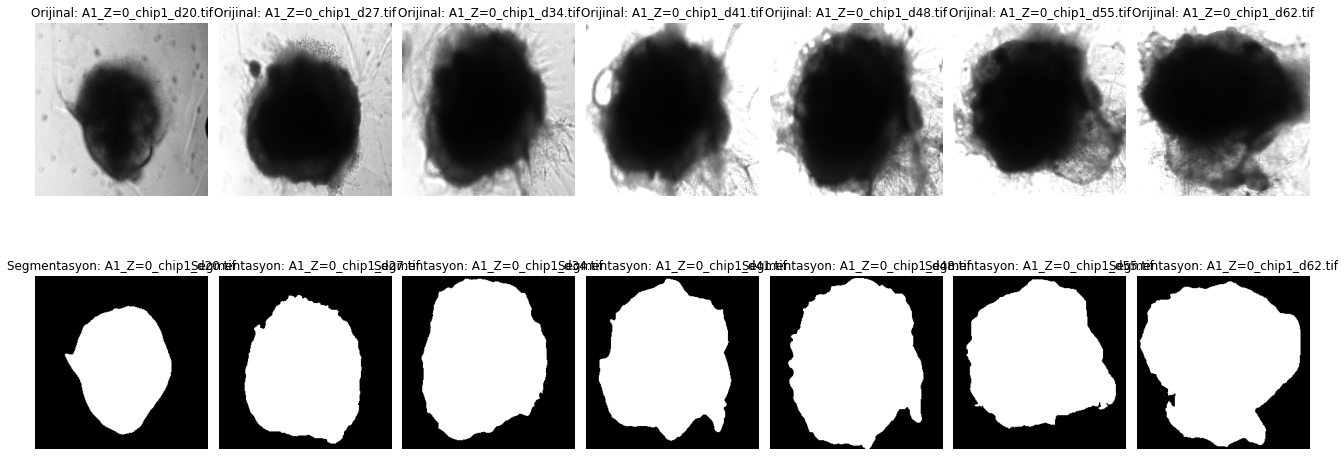

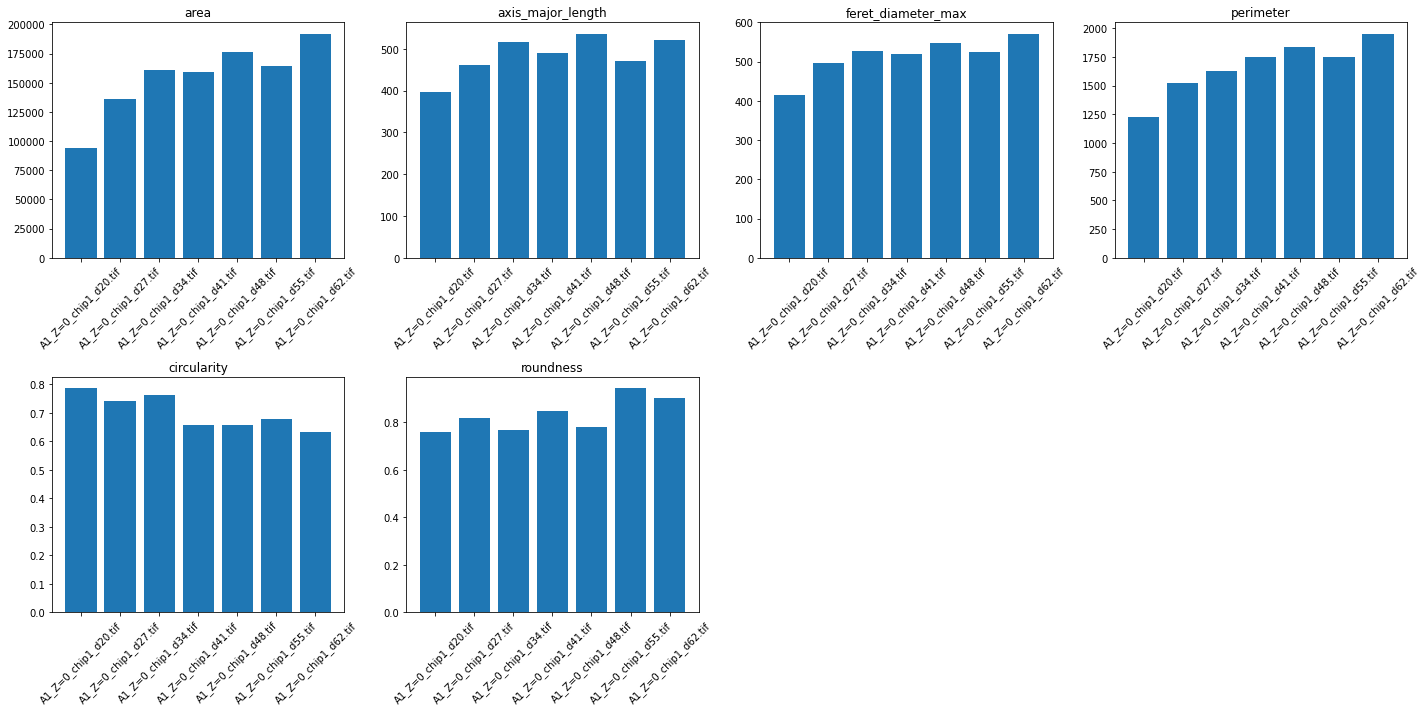

,area,axis_major_length,feret_diameter_max,perimeter,circularity,roundness,_Image_Name
0,94154.791373,397.020311,413.754847,1226.560024,0.786456,0.760549,A1_Z=0_chip1_d20.tif
1,136269.798610,461.095372,495.873047,1520.700569,0.740495,0.816071,A1_Z=0_chip1_d27.tif
2,160685.309450,516.118143,528.274284,1625.499589,0.764209,0.768047,A1_Z=0_chip1_d34.tif
3,159491.351327,490.031098,519.069784,1745.876287,0.657537,0.845668,A1_Z=0_chip1_d41.tif
4,176696.474439,536.471555,548.442187,1838.151773,0.657166,0.781708,A1_Z=0_chip1_d48.tif
5,164528.362159,471.214800,523.979390,1746.617347,0.677727,0.943437,A1_Z=0_chip1_d55.tif
6,192073.349174,520.885936,571.463793,1953.685250,0.632365,0.901347,A1_Z=0_chip1_d62.tif


In [ ]:
run_segmentation_analysis(
    model_path="path/to/model4_unet.h5",
    folder_path="path/to/images/",
    output_csv_path="output/segmentation_results.csv"
)

📈 4. Output Overview

* For each image, segmentation masks are computed using the U-Net model.
* The following metrics are extracted using skimage.measure:
    * area_um2 – area in µm² (converted from pixel²)
    * feret_um – Feret’s diameter (µm)
    * axis_major_length_um – major axis length (µm)
    * perimeter_um – object perimeter (µm)
    * circularity – 4π·area / perimeter² (unitless)
    * roundness – area / π·(major_axis/2)² (unitless)
    * image_name – the original filename
* Output includes:
    * A CSV file containing all per-object metrics.
    * Side-by-side visualizations of original vs segmented images.
    * Metric bar plots averaged per image.

## 🧪 Embryoid Body (EB) Segmentation and Quantification


This section explains how to run segmentation on EB images using a pre-trained U-Net model and how to extract morphological features such as area, feret diameter, and object count, all scaled to micrometer units.

🧠 Step-by-Step Usage

🔧 1. Requirements

Make sure you have installed the following libraries:

In [ ]:
pip install numpy pandas scikit-image opencv-python matplotlib tqdm

📦 2. Run the EB Segmentation Script

* Run segmentation on one or multiple images
* Visualize original vs segmented masks
* Save results in a CSV
* Automatically scale features into micrometers

In [ ]:
def segment_eb_images_show(model_path, input_path, output_csv,output_folder,
                            original_size=(1376, 1036), resized_size=(256, 256),
                            threshold=0.5):
  
    scale_x = original_size[0] / resized_size[0]
    scale_y = original_size[1] / resized_size[1]
    scale_factor_area = scale_x * scale_y
    scale_factor_length = np.sqrt((scale_x + scale_y) / 2)

    model = load_model(model_path)
    results = []

    if os.path.isfile(input_path):
        image_files = [input_path]
    else:
        image_files = [os.path.join(input_path, f) for f in os.listdir(input_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]

    for image_path in tqdm(image_files):
        image_name = os.path.basename(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"❌ No image. Check Path: {image_path}")
            continue

        resized_image = cv2.resize(image, resized_size)
        image_input = resized_image.astype(np.float32) / 255.0
        image_input = np.expand_dims(image_input, axis=(0, -1))

        prediction = (model.predict(image_input)[0, :, :, 0] > threshold).astype(np.uint8)
        labeled = measure.label(prediction)
        props = measure.regionprops(labeled)

        for region in props:
            area_px = region.area
            feret_px = region.feret_diameter_max
            results.append({
                "image": image_name,
                "area_um2": area_px * scale_factor_area,
                "feret_um": feret_px * scale_factor_length,
                "object_count": np.nan
            })

        results.append({
            "image": image_name,
            "area_um2": np.nan,
            "feret_um": np.nan,
            "object_count": len(props)
        })

        # Görselleştir
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(resized_image, cmap='gray')
        plt.title(f"Original: {image_name}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(prediction, cmap='gray')
        plt.title(f"Segmented")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    # mask ve overlay görselleri kaydet
    cv2.imwrite(os.path.join(output_folder, "masks", f"{image_name}_mask.png"), prediction * 255)

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"✅ Results saved as CSV: {output_csv}")

🖼️ 3. Output Details

For each input image, the function:
* Segments EB regions using a U-Net model
* Displays side-by-side original and segmented masks
* Measures:
	* area_um2: Object area (in µm²)
	* feret_um: Maximum Feret diameter (in µm)
	* object_count: Total number of detected regions
* Saves:
	*.png masks inside output_folder/masks/
	* Measurement results in the provided CSV path

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 431ms/step


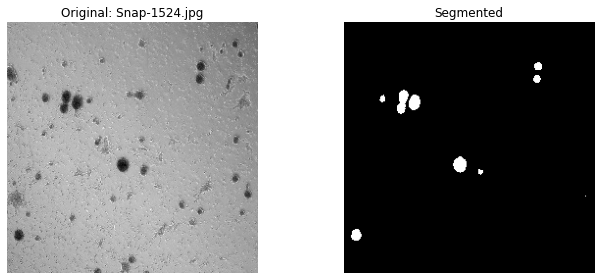

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

✅ Sonuçlar CSV olarak kaydedildi: /Users/burakkahveci/Downloads/segmentation_results_scaled.csv


In [ ]:
segment_eb_images_show(
    model_path="models/segmentation_EB_BrAIn_model_fold5.h5",
    input_path="test_images/Snap-1524.jpg",
    output_csv="results/segmentation_results_scaled.csv",
    output_folder="results/"
)

# Rosette Detection

This section explains how to use a pre-trained YOLOv5 model to detect rosettes in brain organoid images from the terminal.

### 🔧 1. Install YOLOv5

Clone the YOLOv5 repository and install its dependencies:

In [ ]:
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install -r requirements.txt

### 📦 2. Prepare Your Trained Model

Place trained model (e.g., best.pt) in a known location.

Example path:

In [ ]:
runs/detect/train24/weights/best.pt

### 🖼️ 3. Run Prediction on Images

Use the yolo predict command to detect rosettes in a single image:

In [ ]:
yolo predict model=runs/detect/train24/weights/best.pt source='path/to/image.jpg'

To run detection on a folder of images:

In [ ]:
yolo predict model=runs/detect/train24/weights/best.pt source='path/to/images_folder/'

### 📁 4. Check the Results

The output images with rosette bounding boxes will be saved in:

In [ ]:
runs/predict/

### ✅ Example full command:

In [ ]:
cd yolov5
yolo predict model=runs/detect/train24/weights/best.pt source='/Users/burakkahveci/Documents/Codes/BrAIn/revision/Snap-222.jpg'